In [49]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [50]:
class NN(nn.Module):
    def __init__(self, 
                 nodes = 128,
                 layers = 4,
                 exst = 3,
                 nf = 2,        # l and kp policy
                 hidden_bias = True):
        super().__init__()
        self.nodes= nodes
        self.layers = layers
        self.hidden_bias = hidden_bias
        
        # torch.manual_seed(1234)
        module = []
        module.append(nn.Linear(1,self.nodes,bias=self.hidden_bias))    # input layer
        module.append(nn.Tanh())
        
        for i in range(self.layers-1):      # hidden layers
            module.append(nn.Linear(self.nodes,self.nodes,bias=self.hidden_bias))
            module.append(nn.Tanh())  
            
        module.append(nn.Linear(self.nodes,exst*nf))      # output layer
        module.append(nn.Softplus(beta=1.0))     # ensure positive
        
        self.polhat = nn.Sequential(*module)


    def forward(self, x):
        polhat_out = self.polhat(x)
        return  polhat_out

In [51]:
class Data_loader(Dataset):
    
    def __init__(self,kspace):
        self.kspace = kspace
        self.len = self.kspace.shape[0]

    def __getitem__(self,index):
            return self.kspace[index]
        
    def __len__(self):
        return self.len

In [52]:
def EEloss(polhat, k):
    
    # labor policy
    l1 = polhat(k)[:,[0]]
    l2 = polhat(k)[:,[1]]
    l3 = polhat(k)[:,[2]]
    
    # kp policy
    kp1 = polhat(k)[:,[3]]
    kp2 = polhat(k)[:,[4]]
    kp3 = polhat(k)[:,[5]]
    
    # discretized exogenous states
    z = torch.tensor([-0.0102, -0.0003, 0.0096])
    transmat = torch.tensor([[0.9506, 0.0488, 0.0006],
                             [0.0244, 0.9512, 0.0244],
                             [0.0006, 0.0488, 0.9506]])

    # consumption policy
    c1 = 1 / (l1**1.33) * 0.67 * torch.exp(z[0]) * k**0.33
    c2 = 1 / (l2**1.33) * 0.67 * torch.exp(z[1]) * k**0.33
    c3 = 1 / (l3**1.33) * 0.67 * torch.exp(z[2]) * k**0.33
    
    # capital policy
    kp1rhs = torch.exp(z[0]) * k**0.33 * l1**0.67 + 0.9*k - c1     # want to enforce non-negativity constraint here
    kp2rhs = torch.exp(z[1]) * k**0.33 * l2**0.67 + 0.9*k - c2
    kp3rhs = torch.exp(z[2]) * k**0.33 * l3**0.67 + 0.9*k - c3
    
    # next period kp and labor policy
    polp1 = polhat(kp1)
    polp2 = polhat(kp2)
    polp3 = polhat(kp3)
    
    lp1 = polp1[:,[0]]
    lp2 = polp2[:,[1]]
    lp3 = polp3[:,[2]]
    
    cp1 = 1 / (lp1**1.33) * 0.67 * torch.exp(z) * kp1**0.33
    cp2 = 1 / (lp2**1.33) * 0.67 * torch.exp(z) * kp2**0.33
    cp3 = 1 / (lp3**1.33) * 0.67 * torch.exp(z) * kp3**0.33
    
    # Euler equation
    res1 = torch.mm(0.97 * c1/cp1 * (0.33*torch.exp(z) * kp1**(-0.67) * lp1**0.67 + 0.9), transmat[[0],:].T) - 1
    res2 = torch.mm(0.97 * c2/cp2 * (0.33*torch.exp(z) * kp2**(-0.67) * lp2**0.67 + 0.9), transmat[[1],:].T) - 1
    res3 = torch.mm(0.97 * c3/cp3 * (0.33*torch.exp(z) * kp3**(-0.67) * lp3**0.67 + 0.9), transmat[[2],:].T) - 1
    res4 = kp1 - kp1rhs
    res5 = kp2 - kp2rhs
    res6 = kp3 - kp3rhs
    
    loss1 = res1.pow(2).mean()
    loss2 = res2.pow(2).mean()
    loss3 = res3.pow(2).mean()
    loss4 = res4.pow(2).mean()
    loss5 = res5.pow(2).mean()
    loss6 = res6.pow(2).mean()
    
    return loss1, loss2, loss3, loss4, loss5, loss6
    

In [53]:
# set up capital space
kss = 3.7612
kmin = 0.1*kss
kmax = 2*kss
nk = 1000
kspace = torch.linspace(kmin, kmax, nk).view(nk, 1)

# construct data loader
dataset = Data_loader(kspace)
train = DataLoader(kspace, batch_size=20, shuffle=True)

# set up neural net
polhat = NN()
optimizer = torch.optim.Adam(polhat.parameters(), lr=1e-3, weight_decay=0.0)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)

In [54]:
max_epochs = 1000
loss_hist = []

# training
for epoch in range(max_epochs):
    for index, k in enumerate(train):
        
        loss1, loss2, loss3, loss4, loss5, loss6 = EEloss(polhat, k)
        loss = loss1 + loss2 + loss3 + 0.2*loss4 + 0.2*loss5 + 0.2*loss6
        loss_hist.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    scheduler.step()
    
    if epoch % 100 == 0:
        print("epoch:",epoch, ",","MSE Residuals:","{:.2e}".format(loss.item())) 
           

epoch: 0 , MSE Residuals: 6.29e-01
epoch: 100 , MSE Residuals: 6.43e-05
epoch: 200 , MSE Residuals: 2.34e-05
epoch: 300 , MSE Residuals: 4.33e-06
epoch: 400 , MSE Residuals: 1.54e-06
epoch: 500 , MSE Residuals: 6.01e-07
epoch: 600 , MSE Residuals: 5.37e-07
epoch: 700 , MSE Residuals: 5.98e-08
epoch: 800 , MSE Residuals: 2.15e-07
epoch: 900 , MSE Residuals: 8.38e-08


Text(0, 0.5, 'MSE Residuals')

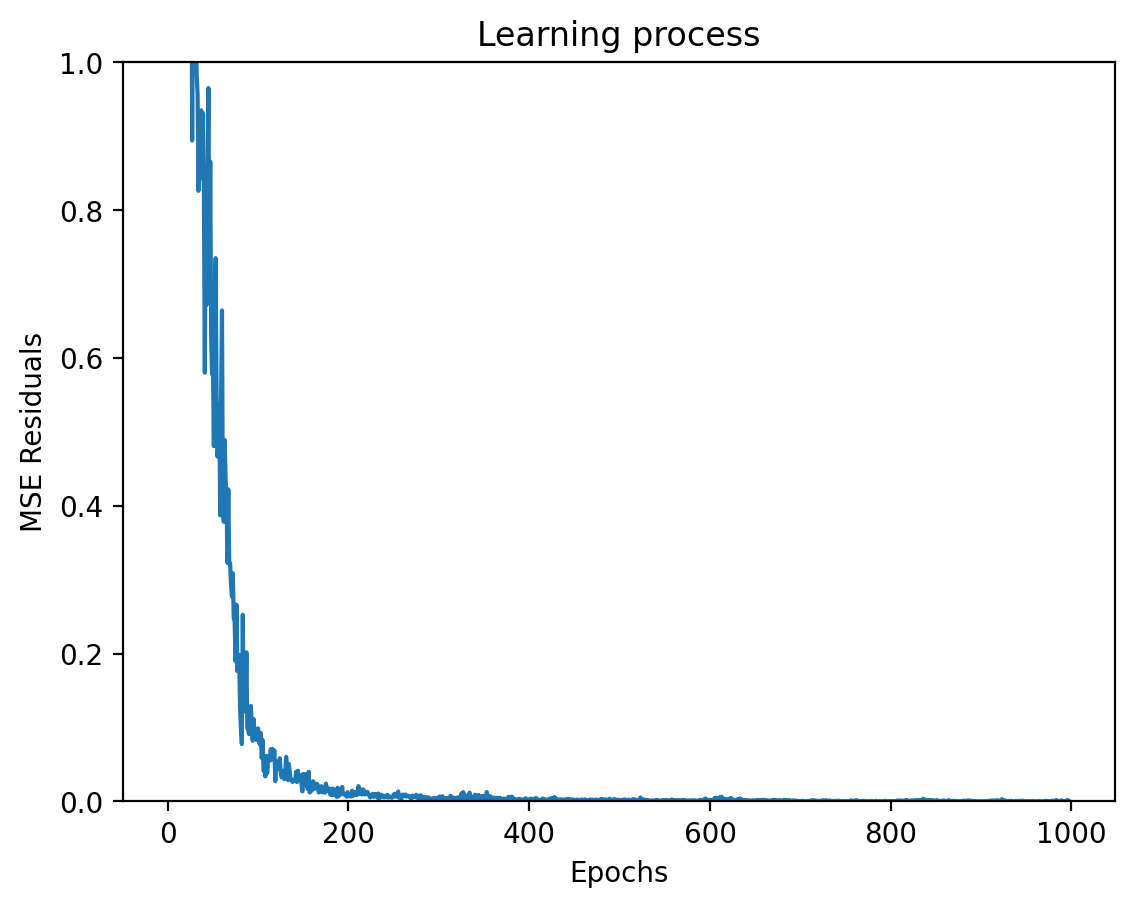

In [55]:
plt.figure(dpi=200)
plt.plot(np.array(loss_hist[1:1000]))
plt.ylim([0,1])
plt.title('Learning process')
plt.xlabel('Epochs')
plt.ylabel('MSE Residuals')

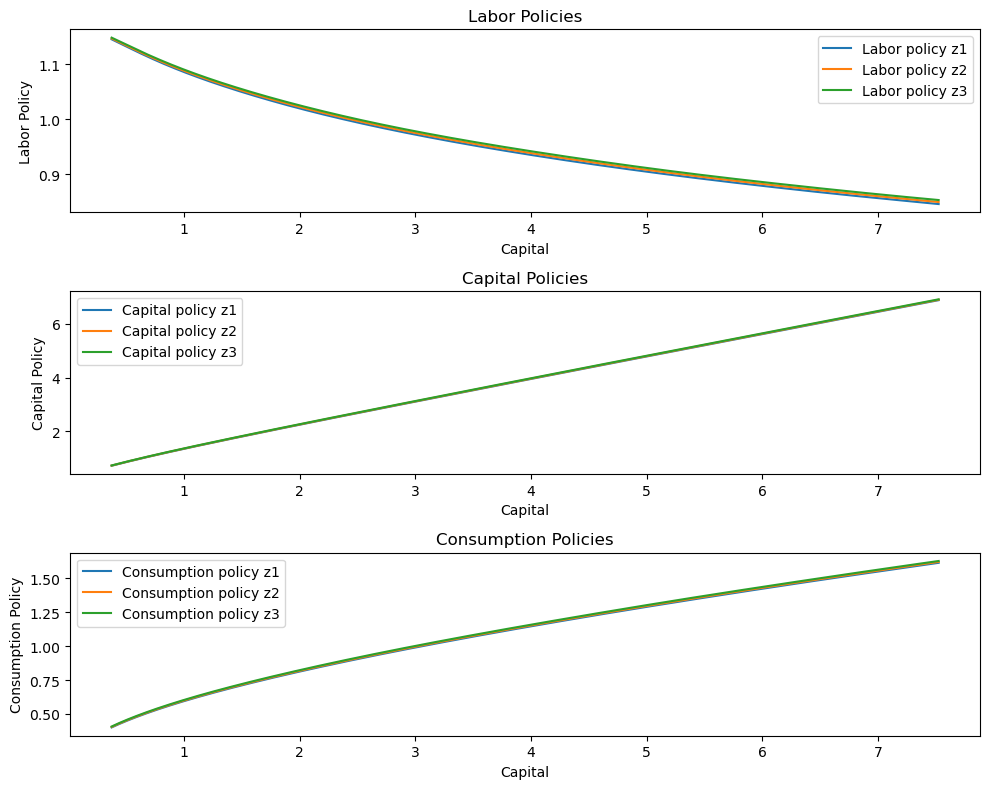

In [56]:
polmat = polhat(kspace).detach()

fig, axs = plt.subplots(3, 1, figsize=(10, 8))

# Plot labor policies
axs[0].plot(kspace, polmat[:, [0]], label='Labor policy z1')
axs[0].plot(kspace, polmat[:, [1]], label='Labor policy z2')
axs[0].plot(kspace, polmat[:, [2]], label='Labor policy z3')
axs[0].legend()
axs[0].set_xlabel('Capital')
axs[0].set_ylabel('Labor Policy')
axs[0].set_title('Labor Policies')

# Plot capital policies
axs[1].plot(kspace, polmat[:, [3]], label='Capital policy z1')
axs[1].plot(kspace, polmat[:, [4]], label='Capital policy z2')
axs[1].plot(kspace, polmat[:, [5]], label='Capital policy z3')
axs[1].legend()
axs[1].set_xlabel('Capital')
axs[1].set_ylabel('Capital Policy')
axs[1].set_title('Capital Policies')

# Compute consumption policies
l1 = polmat[:, [0]]
l2 = polmat[:, [1]]
l3 = polmat[:, [2]]
z = torch.tensor([-0.0102, -0.0003, 0.0096])

c1 = 1 / (l1**1.33) * 0.67 * torch.exp(z[0]) * kspace**0.33
c2 = 1 / (l2**1.33) * 0.67 * torch.exp(z[1]) * kspace**0.33
c3 = 1 / (l3**1.33) * 0.67 * torch.exp(z[2]) * kspace**0.33

# Plot consumption policies
axs[2].plot(kspace, c1, label='Consumption policy z1')
axs[2].plot(kspace, c2, label='Consumption policy z2')
axs[2].plot(kspace, c3, label='Consumption policy z3')
axs[2].legend()
axs[2].set_xlabel('Capital')
axs[2].set_ylabel('Consumption Policy')
axs[2].set_title('Consumption Policies')



plt.tight_layout()
plt.show()